In [4]:
%matplotlib inline
#Reference from https://pytorch.org/

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../AddMoreData061823/Class1/TTV'
l = []
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
#l.append(datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test']))
image_datasetss = torch.utils.data.ConcatDataset(l)
image_datasets = {}
image_datasets['train'] = image_datasetss
image_datasets['test'] = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['test'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['test'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(len( image_datasets['train']))
print(len( image_datasets['val']))
print(len( image_datasets['test']))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
3004
88
106


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



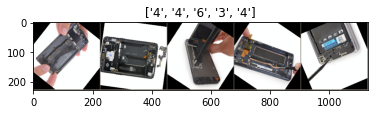

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs+1):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(labels)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)           
        
            m = nn.Softmax(dim=1)
            proOutput = m(outputs)
            pros = proOutput.detach().cpu().numpy()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: %s with %s probabilities' %(class_names[preds[j]], round(pro[j].item(),4)))
                print('Actual label: %s' %(class_names[labels[j].item()]))
                for jj in range(10):
                    print('predicted: %s with %s probabilities' %(class_names[jj], round(pros[j][jj],4)))
                #print('predicted: %s with %s probabilities' %(class_names[1], round(pros[j][1],4)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)
        

#visualize_model(model_ft, 6)

In [10]:
model_ft = models.googlenet(pretrained=True) #load googlenet.

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [11]:
ep = 100
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=ep)

Epoch 1/100
----------
train Loss: 1.8634 Acc: 0.3139
val Loss: 1.4955 Acc: 0.4659

Epoch 2/100
----------
train Loss: 1.3571 Acc: 0.5360
val Loss: 1.1909 Acc: 0.6364

Epoch 3/100
----------
train Loss: 1.0611 Acc: 0.6352
val Loss: 1.2026 Acc: 0.6364

Epoch 4/100
----------
train Loss: 0.8366 Acc: 0.7160
val Loss: 1.1484 Acc: 0.6364

Epoch 5/100
----------
train Loss: 0.6704 Acc: 0.7730
val Loss: 1.0179 Acc: 0.6705

Epoch 6/100
----------
train Loss: 0.5638 Acc: 0.8123
val Loss: 0.9094 Acc: 0.7386

Epoch 7/100
----------
train Loss: 0.4386 Acc: 0.8572
val Loss: 1.1484 Acc: 0.7159

Epoch 8/100
----------
train Loss: 0.2973 Acc: 0.9111
val Loss: 0.9284 Acc: 0.7614

Epoch 9/100
----------
train Loss: 0.2502 Acc: 0.9298
val Loss: 0.9611 Acc: 0.7500

Epoch 10/100
----------
train Loss: 0.2323 Acc: 0.9284
val Loss: 0.9474 Acc: 0.7273

Epoch 11/100
----------
train Loss: 0.2231 Acc: 0.9397
val Loss: 0.9477 Acc: 0.7159

Epoch 12/100
----------
train Loss: 0.2021 Acc: 0.9424
val Loss: 0.9378 Ac

val Loss: 0.9457 Acc: 0.7500

Epoch 98/100
----------
train Loss: 0.1758 Acc: 0.9517
val Loss: 1.0355 Acc: 0.6818

Epoch 99/100
----------
train Loss: 0.1605 Acc: 0.9567
val Loss: 0.9840 Acc: 0.7727

Epoch 100/100
----------
train Loss: 0.1609 Acc: 0.9554
val Loss: 0.9376 Acc: 0.7500

Epoch 101/100
----------
train Loss: 0.1753 Acc: 0.9484
val Loss: 0.9769 Acc: 0.7614

Training complete in 31m 3s
Best val Acc: 0.818182


In [12]:
visualize_model(model_ft, 36)

Actual label: 4
predicted: 0 with 0.0093 probabilities
predicted: 1 with 0.0019 probabilities
predicted: 2 with 0.6584 probabilities
predicted: 3 with 0.0443 probabilities
predicted: 4 with 0.2541 probabilities
predicted: 5 with 0.0232 probabilities
predicted: 6 with 0.0006 probabilities
predicted: 7 with 0.008 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0002 probabilities


Actual label: 6
predicted: 0 with 0.0007 probabilities
predicted: 1 with 0.0014 probabilities
predicted: 2 with 0.2382 probabilities
predicted: 3 with 0.0039 probabilities
predicted: 4 with 0.044 probabilities
predicted: 5 with 0.0075 probabilities
predicted: 6 with 0.686 probabilities
predicted: 7 with 0.0056 probabilities
predicted: 8 with 0.0124 probabilities
predicted: 9 with 0.0002 probabilities


Actual label: 7
predicted: 0 with 0.0005 probabilities
predicted: 1 with 0.001 probabilities
predicted: 2 with 0.0013 probabilities
predicted: 3 with 0.0061 probabilities
predicted: 4 with 0.0009 probabilities
predicted: 5 with 0.0007 probabilities
predicted: 6 with 0.0011 probabilities
predicted: 7 with 0.9881 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0003 probabilities


Actual label: 2
predicted: 0 with 0.0119 probabilities
predicted: 1 with 0.0144 probabilities
predicted: 2 with 0.0369 probabilities
predicted: 3 with 0.2799 probabilities
predicted: 4 with 0.0402 probabilities
predicted: 5 with 0.0033 probabilities
predicted: 6 with 0.0983 probabilities
predicted: 7 with 0.5094 probabilities
predicted: 8 with 0.0056 probabilities
predicted: 9 with 0.0002 probabilities


Actual label: 6
predicted: 0 with 0.0021 probabilities
predicted: 1 with 0.0026 probabilities
predicted: 2 with 0.0054 probabilities
predicted: 3 with 0.0158 probabilities
predicted: 4 with 0.007 probabilities
predicted: 5 with 1e-04 probabilities
predicted: 6 with 0.5996 probabilities
predicted: 7 with 0.3672 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0002 probabilities


Actual label: 6
predicted: 0 with 0.0015 probabilities
predicted: 1 with 0.0019 probabilities
predicted: 2 with 0.034 probabilities
predicted: 3 with 0.115 probabilities
predicted: 4 with 0.0057 probabilities
predicted: 5 with 0.0303 probabilities
predicted: 6 with 0.8003 probabilities
predicted: 7 with 0.0037 probabilities
predicted: 8 with 0.003 probabilities
predicted: 9 with 0.0045 probabilities


Actual label: 1
predicted: 0 with 0.0389 probabilities
predicted: 1 with 0.0519 probabilities
predicted: 2 with 0.1908 probabilities
predicted: 3 with 0.0619 probabilities
predicted: 4 with 0.5912 probabilities
predicted: 5 with 0.0009 probabilities
predicted: 6 with 0.0587 probabilities
predicted: 7 with 0.0047 probabilities
predicted: 8 with 0.0011 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 4
predicted: 0 with 0.0004 probabilities
predicted: 1 with 0.0004 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0002 probabilities
predicted: 4 with 0.9796 probabilities
predicted: 5 with 0.0076 probabilities
predicted: 6 with 0.0074 probabilities
predicted: 7 with 0.0043 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 1e-04 probabilities


Actual label: 7
predicted: 0 with 0.0154 probabilities
predicted: 1 with 0.0003 probabilities
predicted: 2 with 0.0065 probabilities
predicted: 3 with 0.5394 probabilities
predicted: 4 with 0.2539 probabilities
predicted: 5 with 0.0181 probabilities
predicted: 6 with 0.1301 probabilities
predicted: 7 with 0.0354 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0008 probabilities


Actual label: 4
predicted: 0 with 0.0004 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 1e-04 probabilities
predicted: 3 with 0.0003 probabilities
predicted: 4 with 0.9559 probabilities
predicted: 5 with 0.0 probabilities
predicted: 6 with 0.0005 probabilities
predicted: 7 with 0.0425 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 9
predicted: 0 with 0.0014 probabilities
predicted: 1 with 0.0009 probabilities
predicted: 2 with 1e-04 probabilities
predicted: 3 with 0.006 probabilities
predicted: 4 with 0.0027 probabilities
predicted: 5 with 1e-04 probabilities
predicted: 6 with 0.0015 probabilities
predicted: 7 with 0.0066 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.9807 probabilities


Actual label: 3
predicted: 0 with 0.0019 probabilities
predicted: 1 with 0.0007 probabilities
predicted: 2 with 0.0004 probabilities
predicted: 3 with 0.0376 probabilities
predicted: 4 with 0.9338 probabilities
predicted: 5 with 0.02 probabilities
predicted: 6 with 0.0004 probabilities
predicted: 7 with 0.0045 probabilities
predicted: 8 with 0.0002 probabilities
predicted: 9 with 0.0005 probabilities


Actual label: 5
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0142 probabilities
predicted: 4 with 0.0018 probabilities
predicted: 5 with 0.9801 probabilities
predicted: 6 with 0.0011 probabilities
predicted: 7 with 0.0025 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 8
predicted: 0 with 0.0008 probabilities
predicted: 1 with 0.0025 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0 probabilities
predicted: 4 with 0.0008 probabilities
predicted: 5 with 0.0 probabilities
predicted: 6 with 0.0 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.9958 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 3
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0008 probabilities
predicted: 2 with 0.001 probabilities
predicted: 3 with 0.9926 probabilities
predicted: 4 with 0.0046 probabilities
predicted: 5 with 1e-04 probabilities
predicted: 6 with 0.0006 probabilities
predicted: 7 with 0.0003 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 4
predicted: 0 with 0.0 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0 probabilities
predicted: 4 with 0.9996 probabilities
predicted: 5 with 1e-04 probabilities
predicted: 6 with 0.0 probabilities
predicted: 7 with 1e-04 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 3
predicted: 0 with 0.0095 probabilities
predicted: 1 with 0.0308 probabilities
predicted: 2 with 1e-04 probabilities
predicted: 3 with 0.0007 probabilities
predicted: 4 with 1e-04 probabilities
predicted: 5 with 0.0011 probabilities
predicted: 6 with 0.005 probabilities
predicted: 7 with 0.0002 probabilities
predicted: 8 with 0.9526 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 6
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0013 probabilities
predicted: 2 with 0.0004 probabilities
predicted: 3 with 1e-04 probabilities
predicted: 4 with 0.0024 probabilities
predicted: 5 with 0.0 probabilities
predicted: 6 with 0.9958 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 6
predicted: 0 with 0.1999 probabilities
predicted: 1 with 0.0092 probabilities
predicted: 2 with 0.0003 probabilities
predicted: 3 with 0.0106 probabilities
predicted: 4 with 0.4137 probabilities
predicted: 5 with 0.0008 probabilities
predicted: 6 with 0.065 probabilities
predicted: 7 with 0.2999 probabilities
predicted: 8 with 0.0002 probabilities
predicted: 9 with 0.0004 probabilities


Actual label: 6
predicted: 0 with 0.0 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0009 probabilities
predicted: 3 with 0.0042 probabilities
predicted: 4 with 0.0003 probabilities
predicted: 5 with 0.1807 probabilities
predicted: 6 with 0.8045 probabilities
predicted: 7 with 0.0064 probabilities
predicted: 8 with 0.0018 probabilities
predicted: 9 with 0.001 probabilities


Actual label: 5
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 1e-04 probabilities
predicted: 4 with 0.0 probabilities
predicted: 5 with 0.9995 probabilities
predicted: 6 with 0.0003 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 6
predicted: 0 with 0.0004 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0002 probabilities
predicted: 3 with 0.0002 probabilities
predicted: 4 with 0.009 probabilities
predicted: 5 with 0.0411 probabilities
predicted: 6 with 0.9481 probabilities
predicted: 7 with 0.0007 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0002 probabilities


Actual label: 6
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0005 probabilities
predicted: 2 with 0.0792 probabilities
predicted: 3 with 1e-04 probabilities
predicted: 4 with 0.0035 probabilities
predicted: 5 with 0.0014 probabilities
predicted: 6 with 0.9145 probabilities
predicted: 7 with 0.0007 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 1e-04 probabilities


Actual label: 5
predicted: 0 with 0.0115 probabilities
predicted: 1 with 0.008 probabilities
predicted: 2 with 0.006 probabilities
predicted: 3 with 0.0572 probabilities
predicted: 4 with 0.0036 probabilities
predicted: 5 with 0.0011 probabilities
predicted: 6 with 0.0028 probabilities
predicted: 7 with 0.9056 probabilities
predicted: 8 with 0.0018 probabilities
predicted: 9 with 0.0024 probabilities


Actual label: 5
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0 probabilities
predicted: 4 with 0.0 probabilities
predicted: 5 with 0.9988 probabilities
predicted: 6 with 0.0007 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.0004 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 7
predicted: 0 with 0.0002 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0006 probabilities
predicted: 4 with 0.0004 probabilities
predicted: 5 with 0.0012 probabilities
predicted: 6 with 0.0002 probabilities
predicted: 7 with 0.9966 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.0007 probabilities


Actual label: 5
predicted: 0 with 0.0099 probabilities
predicted: 1 with 0.0009 probabilities
predicted: 2 with 0.0005 probabilities
predicted: 3 with 0.0021 probabilities
predicted: 4 with 0.1502 probabilities
predicted: 5 with 0.7552 probabilities
predicted: 6 with 0.0617 probabilities
predicted: 7 with 0.0091 probabilities
predicted: 8 with 0.0003 probabilities
predicted: 9 with 0.0101 probabilities


Actual label: 6
predicted: 0 with 0.0049 probabilities
predicted: 1 with 0.0002 probabilities
predicted: 2 with 0.0011 probabilities
predicted: 3 with 0.0008 probabilities
predicted: 4 with 0.1185 probabilities
predicted: 5 with 0.7034 probabilities
predicted: 6 with 0.1377 probabilities
predicted: 7 with 0.0043 probabilities
predicted: 8 with 1e-04 probabilities
predicted: 9 with 0.029 probabilities


Actual label: 1
predicted: 0 with 0.2367 probabilities
predicted: 1 with 0.2641 probabilities
predicted: 2 with 0.0439 probabilities
predicted: 3 with 0.0463 probabilities
predicted: 4 with 0.0292 probabilities
predicted: 5 with 0.0609 probabilities
predicted: 6 with 0.3049 probabilities
predicted: 7 with 0.0105 probabilities
predicted: 8 with 0.0002 probabilities
predicted: 9 with 0.0032 probabilities


Actual label: 5
predicted: 0 with 0.0048 probabilities
predicted: 1 with 0.0064 probabilities
predicted: 2 with 0.0064 probabilities
predicted: 3 with 0.0849 probabilities
predicted: 4 with 0.1599 probabilities
predicted: 5 with 0.7238 probabilities
predicted: 6 with 0.0057 probabilities
predicted: 7 with 0.0019 probabilities
predicted: 8 with 0.0003 probabilities
predicted: 9 with 0.0058 probabilities


Actual label: 6
predicted: 0 with 0.0006 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0092 probabilities
predicted: 3 with 0.0225 probabilities
predicted: 4 with 0.0033 probabilities
predicted: 5 with 0.9306 probabilities
predicted: 6 with 0.0331 probabilities
predicted: 7 with 1e-04 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0004 probabilities


Actual label: 3
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.9995 probabilities
predicted: 4 with 0.0 probabilities
predicted: 5 with 0.0003 probabilities
predicted: 6 with 0.0 probabilities
predicted: 7 with 1e-04 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 6
predicted: 0 with 0.0003 probabilities
predicted: 1 with 0.0007 probabilities
predicted: 2 with 0.0125 probabilities
predicted: 3 with 0.6843 probabilities
predicted: 4 with 0.0007 probabilities
predicted: 5 with 0.0157 probabilities
predicted: 6 with 0.2796 probabilities
predicted: 7 with 0.0056 probabilities
predicted: 8 with 0.0002 probabilities
predicted: 9 with 0.0005 probabilities


Actual label: 2
predicted: 0 with 0.0375 probabilities
predicted: 1 with 0.1991 probabilities
predicted: 2 with 0.6005 probabilities
predicted: 3 with 0.0022 probabilities
predicted: 4 with 0.1483 probabilities
predicted: 5 with 0.0022 probabilities
predicted: 6 with 0.0017 probabilities
predicted: 7 with 0.0075 probabilities
predicted: 8 with 0.0005 probabilities
predicted: 9 with 0.0005 probabilities


Actual label: 5
predicted: 0 with 0.0 probabilities
predicted: 1 with 1e-04 probabilities
predicted: 2 with 0.0 probabilities
predicted: 3 with 0.0002 probabilities
predicted: 4 with 0.0 probabilities
predicted: 5 with 0.9989 probabilities
predicted: 6 with 0.0007 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.0 probabilities
predicted: 9 with 0.0 probabilities


Actual label: 6
predicted: 0 with 0.0002 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.0066 probabilities
predicted: 3 with 0.0053 probabilities
predicted: 4 with 0.0136 probabilities
predicted: 5 with 0.0894 probabilities
predicted: 6 with 0.8846 probabilities
predicted: 7 with 0.0 probabilities
predicted: 8 with 0.0002 probabilities
predicted: 9 with 0.0 probabilities


In [13]:
correct = 0
total = 0
nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s train images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
#print(confusion_matrix/(total/2)) #Normalizing
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing

Accuracy of the network on the 3004 train images: 99 %
tensor([[ 60.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 188.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 352.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 504.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0., 557.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   5., 753.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 288.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  84.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  56.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.000

In [18]:
correct = 0
total = 0
nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                #print(labels, predicted )
                #print(t.long(), p.long())
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s val images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
#print(confusion_matrix/(total/2)) #Normalizing
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 88 val images: 81 %
tensor([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  8.,  1.,  0.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0., 14.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  2.,  2., 18.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])
tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.6000, 0.2000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.7273, 0.0909, 0.

In [19]:
correct = 0
total = 0
nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                #print(labels, predicted )
                #print(t.long(), p.long())
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s test images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
#print(confusion_matrix/(total/2)) #Normalizing
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 106 test images: 69 %
tensor([[ 0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0., 10.,  1.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  1., 12.,  1.,  0.,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 17.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  2.,  3.,  4., 16.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  7.,  1.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.]])
tensor([[0.0000, 0.3333, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.1667, 0.1667, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.7143, 0.1429, 0.0000, 0.0000, 0.0000, 0.1429, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.8333, 0.0833, 

In [20]:
if not os.path.exists('trained models'):
   os.makedirs('trained models')
PATH = './trained models/GoogLeNet-TTVClass1-BestEP%s.pth' %(ep)
torch.save(model_ft.state_dict(), PATH)